In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Training fold 1/5...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.2412 - loss: 1.9797 - val_accuracy: 0.5420 - val_loss: 1.5420
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4527 - loss: 1.5627 - val_accuracy: 0.6106 - val_loss: 1.1892
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5554 - loss: 1.2801 - val_accuracy: 0.6608 - val_loss: 1.0074
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.6064 - loss: 1.1246 - val_accuracy: 0.6976 - val_loss: 0.9046
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6250 - loss: 1.0398 - val_accuracy: 0.7189 - val_loss: 0.8303
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6518 - loss: 0.9636 - val_accuracy: 0.7311 - val_loss: 0.7799
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6740 - loss: 0.9092 - val_accuracy: 0.7474 - val_loss: 0.7382
Epoch 8/20
299/29

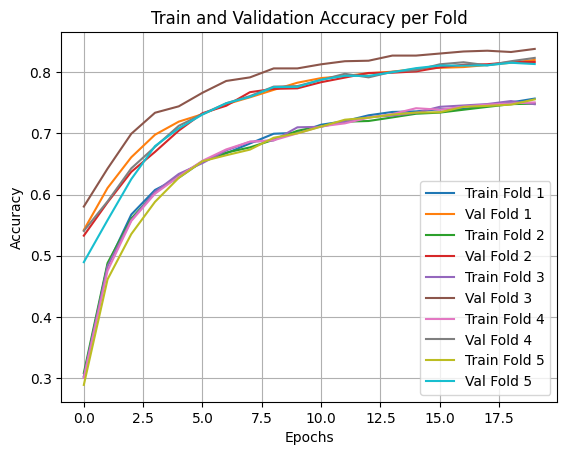


Average Accuracy across 5 folds: 0.8220
Best Accuracy achieved on fold 3: 0.8377


In [3]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = np.load('/content/drive/My Drive/masked_data.npz')
X = data['images']
y = data['labels']

# Normalize the images to [0, 1]
X = X / 255.0

# Number of folds for k-fold cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Track fold results
fold_accuracies = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []
best_accuracy = 0.0
best_fold = -1

# Directory to save the model (if needed)
save_dir = '/content'
os.makedirs(save_dir, exist_ok=True)

# k-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold + 1}/{n_folds}...")

    # Split data into training and validation sets
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define the model using a pre-trained VGG16 base
    base_model = applications.VGG16(
        input_shape=(96, 96, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model layers for initial training
    base_model.trainable = False

    # Add custom classification layers on top
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),  # Dropout
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),  # Additional Dropout
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='softmax')  # 8 output classes
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Add early stopping to avoid overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the training and validation accuracies for this fold
    train_accuracies_per_fold.append(history.history['accuracy'])
    val_accuracies_per_fold.append(history.history['val_accuracy'])

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Fold {fold + 1} Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)

    # Save the weights if this is the best fold so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_fold = fold + 1
        model.save(os.path.join(save_dir, f'weights_vgg16_fold_{best_fold}.keras'))
        print(f"Best model so far saved from fold {best_fold} with accuracy {best_accuracy:.4f}")

# Plot train and validation accuracies for each fold
for fold in range(n_folds):
    plt.plot(train_accuracies_per_fold[fold], label=f"Train Fold {fold + 1}")
    plt.plot(val_accuracies_per_fold[fold], label=f"Val Fold {fold + 1}")

plt.title("Train and Validation Accuracy per Fold")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {n_folds} folds: {average_accuracy:.4f}")
print(f"Best Accuracy achieved on fold {best_fold}: {best_accuracy:.4f}")


In [4]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,938,010 (56.98 MB)

 Trainable params: 74,440 (290.78 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 148,882 (581.57 KB)

In [5]:
# Write the model.py file
model_py_content = """
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications

class Model:
    def __init__(self):
        \"\"\"
        Initializes the model and loads pre-trained weights.
        \"\"\"
        # Define the base model using VGG16
        base_model = applications.VGG16(
            input_shape=(96, 96, 3),
            include_top=False,
            weights=None  # No pre-trained weights here; we load trained weights from file
        )
        base_model.trainable = False

        # Define the full model architecture
        self.neural_network = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),  # Dropout for regularization
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),  # Additional Dropout
            layers.Dense(64, activation='relu'),
            layers.Dense(8, activation='softmax')  # 8 output classes
        ])

        # Build the model by calling it with dummy data
        self.neural_network(tf.random.normal([1, 96, 96, 3]))

        # Load the trained weights
        self.neural_network.load_weights('/content/weights_vgg16_fold_1.keras')  # Adjust filename/path as needed

    def predict(self, X):
        \"\"\"
        Predicts the labels for the input data X.

        Args:
            X (numpy.ndarray): Input data of shape (n_samples, 96, 96, 3).

        Returns:
            numpy.ndarray: Predicted labels of shape (n_samples,).
        \"\"\"
        preds = self.neural_network.predict(X)
        return np.argmax(preds, axis=1)  # Return class indices
"""

# Write the content to a file named "model.py"
with open("model.py", "w") as f:
    f.write(model_py_content)


In [6]:
# Create the ZIP file
from datetime import datetime
from google.colab import files

# Generate a unique filename for the ZIP file
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create the ZIP file with model.py and weights
!zip {filename} model.py weights_vgg16_fold_1.keras

# Download the ZIP file
files.download(filename)

  adding: model.py (deflated 58%)
  adding: weights_vgg16_fold_1.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>